# Variational Autoencoder
In this notebook, we demonstrate the use of a Variational Autoencoder (VAE) to model and analyze a dataset of small molecules. VAEs are a type of generative model that can learn a compressed representation of data and generate new samples that resemble the training data. This makes them particularly useful for working with molecules, where understanding the underlying distribution and generating new molecular structures can be valuable tasks in molecular design.

We will use a dataset of ~7K small molecules [../data/small_mols.csv](../data/small_mols.csv) to train our variational autoencoder.

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## Building a model
We will begin by defining a new model class called `MolecularVAE`:

In [99]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        # Define the layers used in the encoder
        self.conv_1 = nn.Conv1d(35, 20, kernel_size=5)
        self.conv_2 = nn.Conv1d(20, 15, kernel_size=5)
        self.conv_3 = nn.Conv1d(15, 9, kernel_size=5)
        self.linear_0 = nn.Linear(90, 200)
        self.linear_1 = nn.Linear(200, 200)
        self.linear_2 = nn.Linear(200, 200)

        # Define the layers used in the decoder
        self.linear_3 = nn.Linear(200, 200)
        self.gru = nn.GRU(200, 300, 3, batch_first=True)
        self.linear_4 = nn.Linear(300, 22)

        # Define activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    # Encoder function
    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    # Decoder function
    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 35, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

	# Sampling function for the latent space
    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    # Forward pass of the model
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

We also need to define a function for encoding SMILES string as one-hot vectors, and a loss function. Here, we will use the binary cross-entropy (BCE) loss.

In [100]:
import numpy as np
from tqdm import tqdm

# Function to convert SMILES strings to one-hot encodings
def smiles_to_hot(smiles, max_len, char_indices, nchars):
    X = np.zeros((len(smiles), max_len, nchars), dtype=np.float32)
    for i, smile in tqdm(enumerate(smiles)):
        for t, char in enumerate(smile):
            X[i, t, char_indices[char]] = 1
    return X

# Function to calculate the VAE loss using the BCE
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

## Preparing the data

In [136]:
# Preprocess the SMILES strings
all_chars = []
max_len = 35

file_path = '../data/smiles.txt'
smiles_strings = []
with open(file_path, "r") as file:
    smiles_strings = file.readlines()

for smi in smiles_strings:
    characters = [char for char in smi[:-1]]  # Remove newline
    all_chars.append(characters)

# Define the character indices for one-hot encoding
char_indices = {'S':0, '2':1, 'O':2, '[':3, 'o':4, '\\':5, 'c':6, '3':7, 'C':8, ')':9, 's':10, 'N':11, '(':12, 'H':13, ']':14, '#':15, 'n':16, '1':17, '@':18, '/':19, '=':20, ' ':21}

# Convert SMILES strings to one-hot encodings
one_hot_embeddings = smiles_to_hot(all_chars, max_len, char_indices, 22)
print(one_hot_embeddings.shape)

# Split the data into train and test datasets
data_train = one_hot_embeddings[:6000]
smiles_train = smiles_strings[:6000]
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))

data_test = one_hot_embeddings[6000:]
smiles_test = smiles_strings[6000:]
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))

7165it [00:00, 413349.86it/s]

(7165, 35, 22)


## Training the model
Below we will train the VAE for 50 training epochs using a batch size of 100 and learning rate of 0.0001.

Depending on your computer, this may take a few minutes. If you don't want to wait that long, feel free to reduce the number of training epochs and continue with the analysis; the model may not be as good in that case, but you should still be able to get some insights.

In [139]:
import torch.optim as optim

# Define training parameters
batch_size = 100
num_epochs = 100
learning_rate = 0.0001

# Create a dataloader for the train split
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

# Create an instance of the MolecularVAE model
model = MolecularVAE()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []  # For storing the train loss per epoch
test_losses = []  # For storing the test loss per epoch

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0]

        optimizer.zero_grad()   # Zero the gradients at the start of each mini-batch

        output, mean, logvar = model(data)
        loss = vae_loss(output, data, mean, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Store the training loss after each epoch
    train_losses.append(train_loss / len(train_loader.dataset))

    # Save the model after each epoch
    file_path = "VAEmodel.pth"
    torch.save(model.state_dict(), file_path)
    print(f'Epoch {epoch} Loss: {train_loss / len(train_loader.dataset)}')

    # Compute and store the test loss after each epoch
    model.eval()
    with torch.no_grad():
        output_test, mean_test, logvar_test = model(data_test[:][0])
        test_loss = vae_loss(output_test, data_test[:][0], mean_test, logvar_test)
        test_losses.append(test_loss.item() / len(data_test))

Epoch 0 Loss: 73.50829703776041
Epoch 1 Loss: 67.9278202311198
Epoch 2 Loss: 66.21046484375
Epoch 3 Loss: 65.47577579752604
Epoch 4 Loss: 64.55492130533854
Epoch 5 Loss: 62.86428173828125
Epoch 6 Loss: 60.92763850911458
Epoch 7 Loss: 59.65395450846354
Epoch 8 Loss: 58.85088435872396
Epoch 9 Loss: 58.19293269856771
Epoch 10 Loss: 57.76678889973958
Epoch 11 Loss: 57.35919327799479
Epoch 12 Loss: 56.97161946614583
Epoch 13 Loss: 56.8074267578125
Epoch 14 Loss: 56.61781201171875
Epoch 15 Loss: 56.19408984375
Epoch 16 Loss: 55.83105924479167
Epoch 17 Loss: 55.32456787109375
Epoch 18 Loss: 54.953772054036456
Epoch 19 Loss: 54.669305419921876
Epoch 20 Loss: 54.457610188802086
Epoch 21 Loss: 54.30621223958333
Epoch 22 Loss: 53.80200895182292
Epoch 23 Loss: 53.528379557291665
Epoch 24 Loss: 53.33133154296875
Epoch 25 Loss: 53.11048518880208
Epoch 26 Loss: 52.9049287109375
Epoch 27 Loss: 52.736590413411456
Epoch 28 Loss: 52.64700480143229
Epoch 29 Loss: 52.50185725911458
Epoch 30 Loss: 52.245317

## Analysis and best practices
Let's begin by visualizing the loss curves:

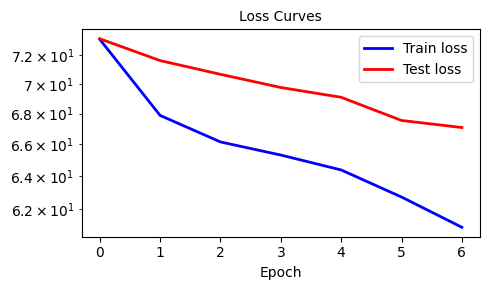

In [138]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(1, 1, 1)

# Plot the loss as a function of the number of training epochs
ax.plot(train_losses, color='blue', lw=1, label='Train loss')
ax.plot(test_losses, color='red', lw=1, label='Test loss')
ax.set_xlabel('Epoch', size=10)
ax.set_title('Loss Curves', size=10)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()

plt.show()

### SMILES reconstruction
Next, let's analyze how well our model can reconstruct SMILES strings from the test set. 

First, we will compute the reconstruction loss for the test set and compare to the training set.

In [104]:
# Create a dataloader for the test split
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True)

# Calculate reconstruction loss on test data and compare to train data
model.eval()
with torch.no_grad():
    test_loss = 0
    for batch_idx, data in enumerate(test_loader):
        data = data[0]

        output, mean, logvar = model(data)
        loss = vae_loss(output, data, mean, logvar)

        test_loss += loss.item()

print(f'Train loss after {epoch + 1} training epochs: {train_loss / len(train_loader.dataset)}')
print(f'Test loss after {epoch + 1} training epochs: {test_loss / len(test_loader.dataset)}')

Train loss after 13 training epochs: 44.23777669270833
Test loss after 13 training epochs: 67.82155394983906


The model appears to be a little overfit, but that should not be a huge issue here.


To see what the SMILES look like, we will define a function for 'decoding' the VAE output embeddings into SMILES, and look at a few SMILES from the training and test sets in detail to see how good the model is at reconstructing them.

In [105]:
# Define a function to convert VAE output embeddings 'back' to SMILES strings
def emb_to_smiles(embedding, indices_char):
    smiles = []
    for one_hot in tqdm(embedding):
        smiles_chars = []
        for vector in one_hot:
            if int(torch.sum(vector)) == 0:
                continue  # Skip padding
            char_index = int(torch.argmax(vector))
            char = indices_char[char_index]
            smiles_chars.append(char)
        smiles.append(''.join(smiles_chars).strip())
    return smiles

# Define the character indices for one-hot encoding
indices_char = {v: k for k, v in char_indices.items()}
print(indices_char)

{0: 'S', 1: '2', 2: 'O', 3: '[', 4: 'o', 5: '\\', 6: 'c', 7: '3', 8: 'C', 9: ')', 10: 's', 11: 'N', 12: '(', 13: 'H', 14: ']', 15: '#', 16: 'n', 17: '1', 18: '@', 19: '/', 20: '=', 21: ' '}


In [130]:
# Let's visualize the reconstructions for the first five training and test set SMILES
model.eval()
with torch.no_grad():
    train_embeddings, _, _ = model(data_train[:5][0])
    test_embeddings, _, _ = model(data_test[:5][0])


# Decode the one-hot encoded SMILES to see how they are deconstructed
decoded_train_smiles = emb_to_smiles(train_embeddings, indices_char)
print('Training set SMILES reconstruction:')
for i, smiles in enumerate(decoded_train_smiles):
	print(f'True: {smiles_train[i][:-1]}, Reconstructed: {smiles}')

print(' ')

decoded_test_smiles = emb_to_smiles(test_embeddings, indices_char)
print('Testing set SMILES reconstruction:')
for i, smiles in enumerate(decoded_test_smiles):
	print(f'True: {smiles_test[i][:-1]}, Reconstructed: {smiles}')

100%|██████████| 5/5 [00:00<00:00, 1173.17it/s]


Training set SMILES reconstruction:
True: C, Reconstructed: CCC@]C]CCCCCCCCCCCCCCCC
True: CC, Reconstructed: CCC@HCCCCCCCCCCCCCCCCCCCCC
True: C=C, Reconstructed: @]]CCCCCCCCCCCCCC1
True: C#C, Reconstructed: CCC@HCCCCCCCCCCCCCCCCCC1
True: CCO, Reconstructed: CC@@]CCCCC]CCCCCCCCCCCC
 


100%|██████████| 5/5 [00:00<00:00, 786.54it/s]

Testing set SMILES reconstruction:
True: O[C@H]1C=CNC1=O, Reconstructed: CCC@@]CCCCCCCCCCCCCCCCCCCC
True: O[C@H]1CCNC1=O, Reconstructed: CC@]]CCCCCCCCCCCCCCCCC
True: OC1=CC=[N]=C[CH]1, Reconstructed: CCCCCCCCCCCCCC11111
True: OC1CCNCC1, Reconstructed: CCCCCCCCCCCCCCC)111111
True: C[C@H]1CCCN1C, Reconstructed: CCC@H]CCCCCCCCCCCCCCCCCCC


### Latent space interpolation
We can also explore the latent space around a particular molecule.

Let's start by visualizing the latent space using PCA, as in the [Dimensionality Reduction](../2-Dimensionality-Reduction/Dimensionality-Reduction.ipynb) notebook.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

_, latent_space, _ = model(data_train[:][0])

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_space)

# Plot the latent space and color points according to SMILES length
plt.figure(figsize=(5,3))

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=[len(smiles) for smiles in smiles_train])
plt.colorbar(label='SMILES length')
plt.title('Latent Space Visualization (PCA)', size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

plt.show()

Now, let's try interpolating between two points in the latent space of our VAE.

In [ ]:
# Define a function for interpolating values along a line between two points in Euclidean space
def interpolate_points(point1, point2, n_inbetween_points=10):
    ratios = np.linspace(0, 1, num=n_inbetween_points)
    vectors = [(1.0 - ratio) * point1 + ratio * point2 for ratio in ratios]
    return torch.stack(vectors)

# Select two random points in the latent space
idx1 = 54  # Can be between 0 and 5997 (i.e., 6000 minus 3)
idx2 = 77  # Can be between 0 and 5997 (i.e., 6000 minus 3)

smiles1 = smiles_train[idx1]
smiles2 = smiles_train[idx2]

point1 = latent_space[idx1]
point2 = latent_space[idx2]

# Generate interpolations
interpolations = interpolate_points(point1, point2)

# Decode the interpolations
model.eval()
with torch.no_grad():
    decoded_interpolations = model.decode(interpolations)

# Print the SMILES corresponding to the interpolated values after decoding
print(f'Point 1: {smiles1}')
for i, embedding in enumerate(decoded_interpolations):
    decoded_smiles = emb_to_smiles(embedding, indices_char)
    print(f'- Interpolation {i}: {decoded_smiles}')
print(f'Point 2: {smiles2}')

### SMILES generation
Finally, we will evaluate how well our VAE works in generating new molecules.

This can be done a number of ways. Below we will try:
* Generating random latent vectors and decoding
* Adding 'noise' to latent space vectors and decoding

#### Decoding random points in the VAE latent space

In [ ]:
num_samples = 10

# Generate random latent vectors
latent_samples = torch.randn(num_samples, len(latent_space[0]))

model.eval()
with torch.no_grad():
    generated_samples = model.decode(latent_samples)

# Print the SMILES corresponding to the random latent vectors after decoding
print(f'Random latent vectors decode to:')
for i, embedding in enumerate(generated_samples):
    decoded_smiles = emb_to_smiles(embedding, indices_char)
    print(f'- Sample {i}: {decoded_smiles}')

# Let's evaluate how many SMILES are novel; `smiles_strings` contains all train and test SMILES
novel_smiles = set(decoded_smiles) & set(smiles_strings)
fraction_novel = len(novel_smiles)/len(decoded_smiles)
print(f'Fraction novel SMILES out of {num_samples} samples: {fraction_novel}')
if fraction_novel > 0:
    print(f'Novel SMILES: {novel_smiles.join(', ')}')